In [46]:
# Mount Google Drive (for Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
except:
    IN_COLAB = False
    print("Not running in Colab - skipping drive mount")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
# 1. Install Dependencies
# We use the pytorch-grad-cam library for robust xAI implementations
!pip install -q grad-cam
!pip install -q opencv-python matplotlib torch torchvision

In [48]:
# 2. Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from torchvision.models import ResNet50_Weights
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import warnings

# Grad-CAM libraries
from pytorch_grad_cam import GradCAMPlusPlus, GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

warnings.filterwarnings('ignore')

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 3. Model Architecture Definition
We must define the exact model architecture used during training to successfully load the weights.

In [49]:
# --- CBAM Modules (Copied from Training Notebook) ---

class ChannelAttention(nn.Module):
    """Channel Attention Module - focuses on 'what' is meaningful."""
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction_ratio, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction_ratio, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = self.sigmoid(avg_out + max_out)
        return x * out

class SpatialAttention(nn.Module):
    """Spatial Attention Module - focuses on 'where' is meaningful."""
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = 3 if kernel_size == 7 else 1
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.sigmoid(self.conv(out))
        return x * out

class CBAM(nn.Module):
    """Convolutional Block Attention Module (CBAM)."""
    def __init__(self, in_channels, reduction_ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction_ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x

# --- Main Model ---

class CBAM_ResNet50(nn.Module):
    """ResNet50 with CBAM attention modules."""
    def __init__(self, num_classes=5, pretrained=False): # Pretrained False for loading weights
        super(CBAM_ResNet50, self).__init__()

        # We load the structure, weights will be loaded from file
        resnet = models.resnet50(weights=None)

        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool

        self.layer1 = resnet.layer1
        self.cbam1 = CBAM(256)

        self.layer2 = resnet.layer2
        self.cbam2 = CBAM(512)

        self.layer3 = resnet.layer3
        self.cbam3 = CBAM(1024)

        self.layer4 = resnet.layer4
        self.cbam4 = CBAM(2048)

        self.avgpool = resnet.avgpool
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.cbam1(x)

        x = self.layer2(x)
        x = self.cbam2(x)

        x = self.layer3(x)
        x = self.cbam3(x)

        x = self.layer4(x)
        x = self.cbam4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        logits = self.fc(x)
        return logits

print("Model architecture defined.")

Model architecture defined.


In [50]:
# 4. Load Trained Model
# Path provided by user
MODEL_PATH = r"/content/drive/MyDrive/6_Project Phoenix_Cervical Cancer Cell Classification/Sipakmed Pipeline v2/cbam_resnet50_cervical/best_model.pth"

def load_model(path, device):
    if not Path(path).exists():
        raise FileNotFoundError(f"Model file not found at {path}")

    checkpoint = torch.load(path, map_location=device)

    # Get class info
    class_names = checkpoint['class_names']
    num_classes = len(class_names)

    # Initialize model
    model = CBAM_ResNet50(num_classes=num_classes, pretrained=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()

    print(f"Model loaded successfully from epoch {checkpoint['epoch']}")
    print(f"Best Validation Accuracy: {checkpoint['best_val_acc']:.4f}")
    print(f"Classes: {class_names}")

    return model, class_names

try:
    model, class_names = load_model(MODEL_PATH, device)
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please check the MODEL_PATH variable.")

Model loaded successfully from epoch 3
Best Validation Accuracy: 0.9531
Classes: ['im_Dyskeratotic', 'im_Koilocytotic', 'im_Metaplastic', 'im_Parabasal', 'im_Superficial-Intermediate']


## 5. GradCAM++ Configuration

We need to define the **target layers** for GradCAM++.
For ResNet-based architectures, the last convolutional layer of the last residual block (`layer4`) is typically the best place to visualize high-level semantic features.
In our CBAM-ResNet50, we have `layer4` followed by `cbam4`. We can target the last bottleneck of `layer4` or the `cbam4` module itself.

In [51]:
# Define target layers
# We target the last Bottleneck block of the ResNet backbone (before the final CBAM)
# This usually captures the high-level spatial features best.
target_layers = [model.layer4[-1]]

# Initialize GradCAM++
cam = GradCAMPlusPlus(model=model, target_layers=target_layers)

print(f"GradCAM++ initialized targeting: {target_layers}")

GradCAM++ initialized targeting: [Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)]


## 6. Visualization Utilities
Helper functions to load images, preprocess them, and display the results.

In [52]:
def get_image_tensor(image_path):
    """Load and preprocess image for the model."""
    # Standard ImageNet normalization
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    return img, img_tensor

def visualize_gradcam(model, cam, image_path, class_names, true_label=None, save_dir=None):
    """Generate and display GradCAM++ visualization."""

    # 1. Load Image
    original_pil, input_tensor = get_image_tensor(image_path)

    # Prepare image for visualization (float32, 0-1 range)
    rgb_img = np.array(original_pil.resize((224, 224)))
    rgb_img = np.float32(rgb_img) / 255

    # 2. Model Prediction
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = F.softmax(outputs, dim=1)
        pred_idx = torch.argmax(probs, dim=1).item()
        pred_class = class_names[pred_idx]
        conf = probs[0, pred_idx].item()

    # 3. Generate CAM
    # If targets is None, it defaults to the highest scoring category
    grayscale_cam = cam(input_tensor=input_tensor, targets=None)
    grayscale_cam = grayscale_cam[0, :] # Take first sample in batch

    # 4. Overlay
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # 5. Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original
    axes[0].imshow(rgb_img)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Heatmap
    axes[1].imshow(grayscale_cam, cmap='jet')
    axes[1].set_title("GradCAM++ Heatmap")
    axes[1].axis('off')

    # Overlay
    axes[2].imshow(visualization)
    title = f"Pred: {pred_class} ({conf:.1%})"
    if true_label:
        title += f"\nTrue: {true_label}"
    axes[2].set_title(title)
    axes[2].axis('off')

    plt.tight_layout()

    if save_dir:
        original_name = Path(image_path).stem
        # Use true_label for filename if provided, otherwise default to predicted class
        # This ensures that when we are specifically looking at samples from known classes,
        # the saved file reflects that true class.
        filename_class_part = true_label if true_label else pred_class
        save_path = Path(save_dir) / f"gradcam_{filename_class_part}_{original_name}.png"
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path)
        print(f"Saved GradCAM visualization to {save_path}")

    plt.show()

    return pred_class, conf

## 7. Run Visualization on Sample Images
Run the cell below to visualize GradCAM++ on images from your dataset.
**Note:** Update `TEST_IMAGE_DIR` to point to a folder containing your test images if needed.

Found 8384 images.

Processing: 001_01_processed.bmp (Class: im_Superficial-Intermediate)
Saved GradCAM visualization to gradcam_outputs/gradcam_im_Superficial-Intermediate_001_01_processed.png


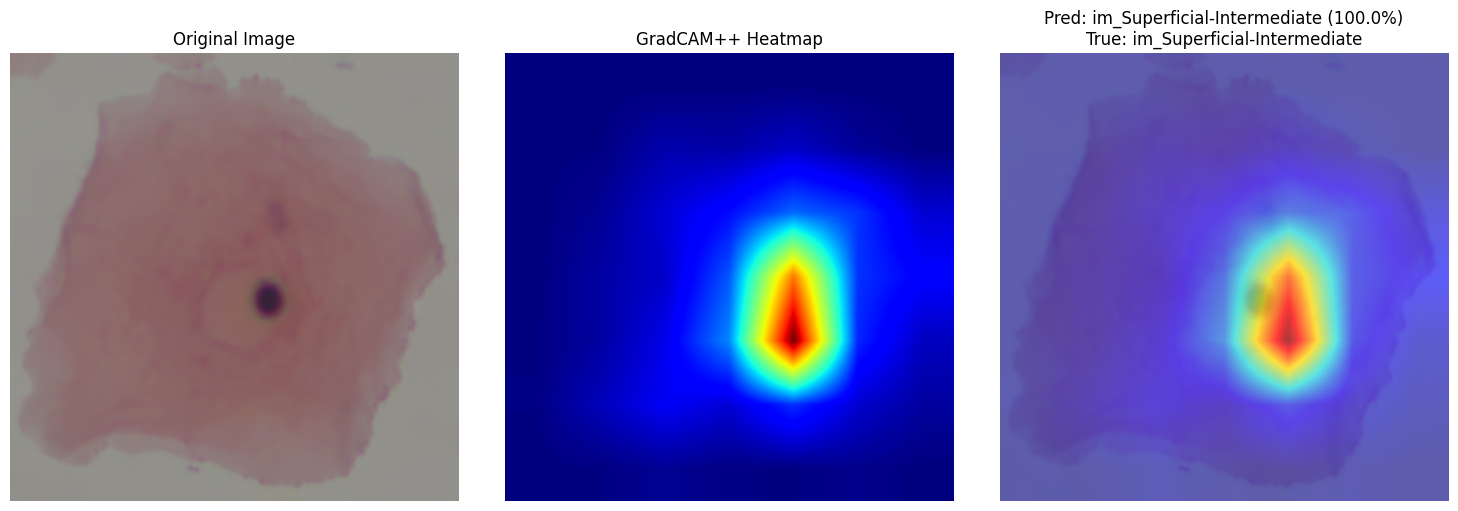


Processing: 001_01_processed.bmp (Class: im_Parabasal)
Saved GradCAM visualization to gradcam_outputs/gradcam_im_Parabasal_001_01_processed.png


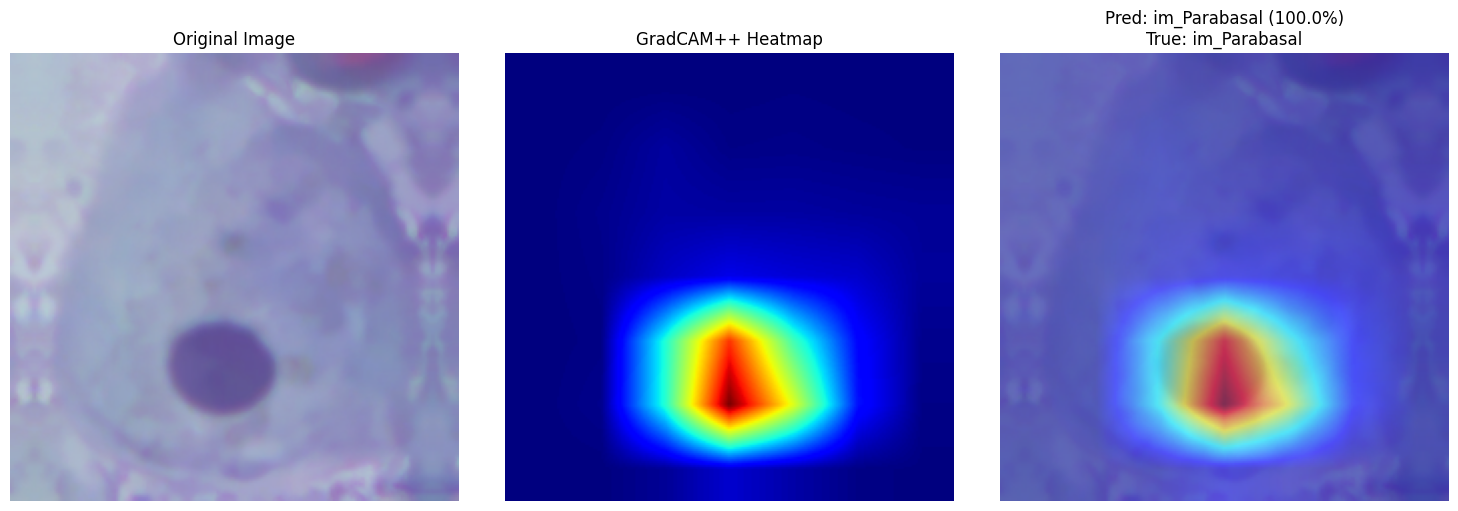


Processing: 001_01_processed.bmp (Class: im_Metaplastic)
Saved GradCAM visualization to gradcam_outputs/gradcam_im_Metaplastic_001_01_processed.png


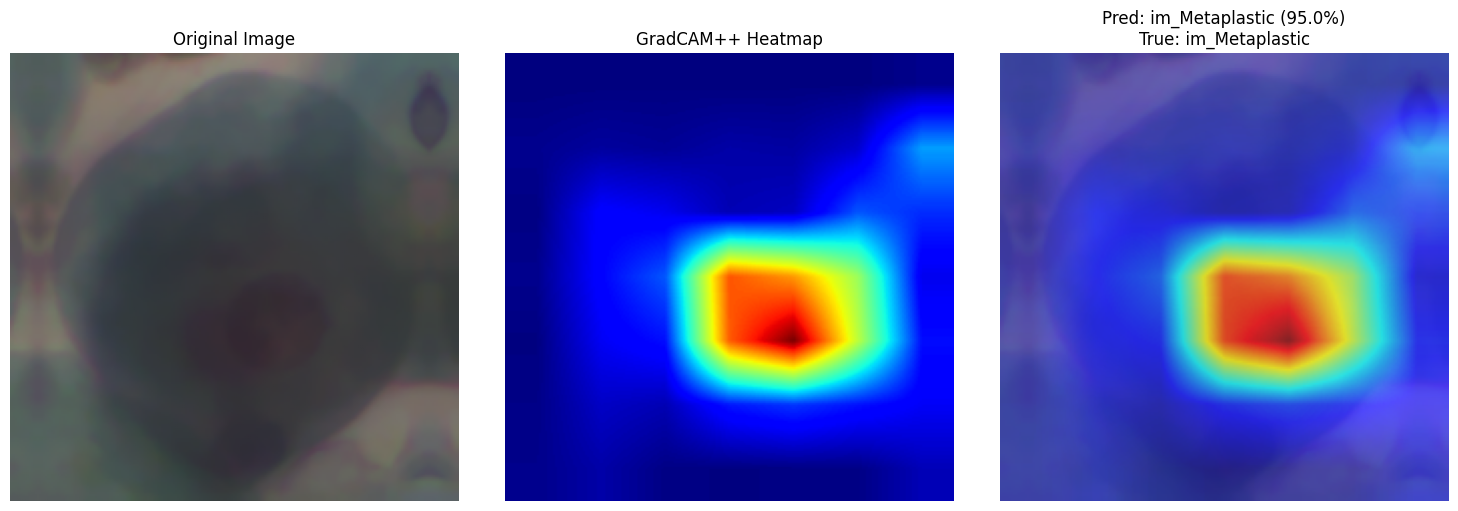


Processing: 001_01_processed.bmp (Class: im_Koilocytotic)
Saved GradCAM visualization to gradcam_outputs/gradcam_im_Koilocytotic_001_01_processed.png


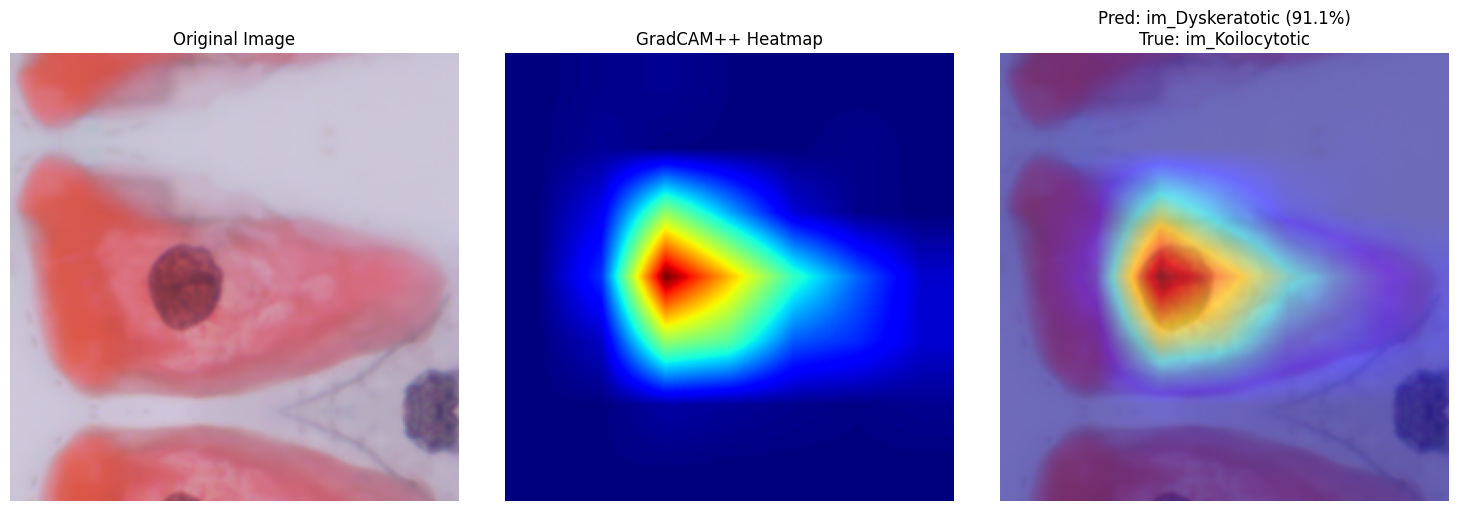


Processing: 001_01_processed.bmp (Class: im_Dyskeratotic)
Saved GradCAM visualization to gradcam_outputs/gradcam_im_Dyskeratotic_001_01_processed.png


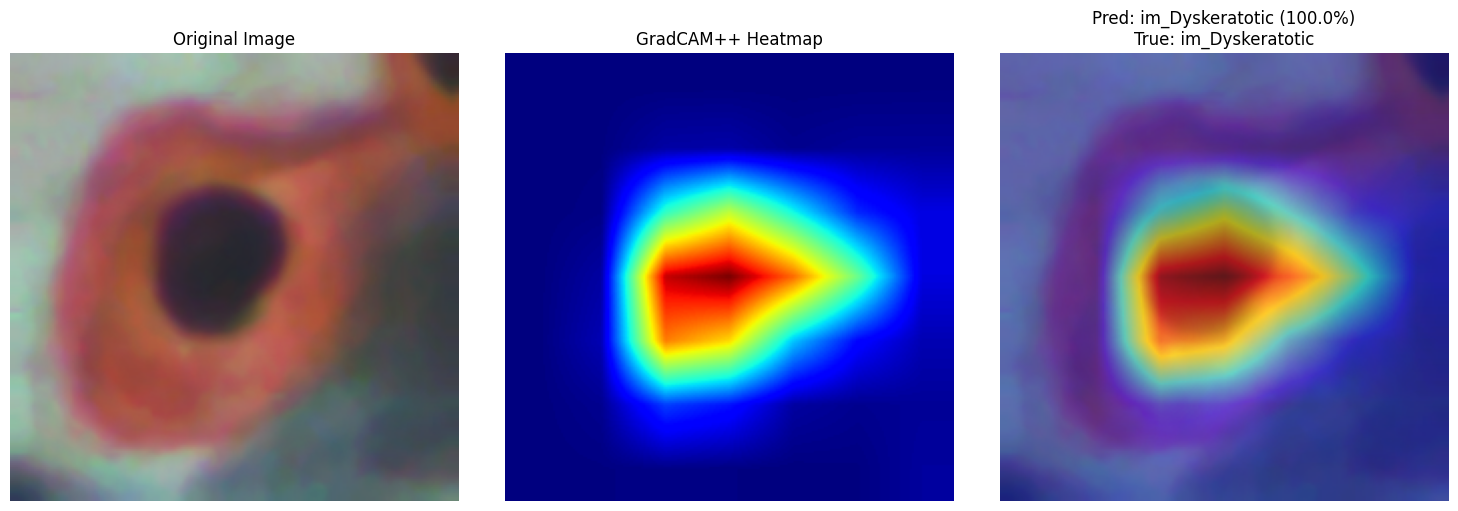

In [53]:
# Configuration for test images
# Try to find some images automatically or set a path
TEST_IMAGE_DIR = Path("/content/drive/MyDrive/6_Project Phoenix_Cervical Cancer Cell Classification/Preprocessed Datasets/Augmented Datasets/Augmented Dataset - Limited Enhancement")

# Define a save directory for the GradCAM++ outputs
GRADCAM_SAVE_DIR = Path("./gradcam_outputs")
if not GRADCAM_SAVE_DIR.exists():
    GRADCAM_SAVE_DIR.mkdir(parents=True, exist_ok=True)
    print(f"Created directory: {GRADCAM_SAVE_DIR}")

# If the dataset folder isn't found, we'll look for any .bmp or .png in the current dir
if not TEST_IMAGE_DIR.exists():
    print(f"Dataset directory '{TEST_IMAGE_DIR}' not found.")
    print("Searching for images in current directory...")
    image_files = list(Path('.').glob('*.bmp')) + list(Path('.').glob('*.png'))
else:
    # Recursive search for images, include png as well
    image_files = list(TEST_IMAGE_DIR.rglob('*.bmp')) + list(TEST_IMAGE_DIR.rglob('*.png'))

if not image_files:
    print("No images found! Please set 'TEST_IMAGE_DIR' to your dataset path.")
else:
    print(f"Found {len(image_files)} images.")

    # Select one image for each class
    samples_per_class = {}
    for img_path in image_files:
        # Infer label from parent folder name (e.g., 'im_Dyskeratotic' in '/path/to/im_Dyskeratotic/image.bmp')
        # We need to go up two levels to get the class folder name if structure is Class/Enhancement/image.bmp
        # Or one level if structure is Class/image.bmp
        parent_dir_name = img_path.parent.name # This gets 'NLM_Only' or 'NLM_CLAHE'
        grandparent_dir_name = img_path.parent.parent.name # This gets the class name e.g. 'im_Superficial-Intermediate'

        # Check if the grandparent folder name is one of our class names
        if grandparent_dir_name in class_names and grandparent_dir_name not in samples_per_class:
            samples_per_class[grandparent_dir_name] = img_path

        # Stop if we've found a sample for each known class
        if len(samples_per_class) == len(class_names):
            break

    if len(samples_per_class) < len(class_names):
        print(f"Warning: Could only find samples for {len(samples_per_class)} out of {len(class_names)} classes.")
        # If not enough samples, fall back to just using the first found images
        if not samples_per_class and image_files: # If no samples per class were found and there are image files
             print("Could not infer class from folder structure; using first available images.")
             for i, class_name in enumerate(class_names):
                 if i < len(image_files):
                     samples_per_class[class_name] = image_files[i]

    # Process and visualize each selected sample
    for class_name, img_path in samples_per_class.items():
        print(f"\nProcessing: {img_path.name} (Class: {class_name})")
        try:
            visualize_gradcam(model, cam, img_path, class_names, class_name, save_dir=GRADCAM_SAVE_DIR)
        except Exception as e:
            print(f"Could not process image {img_path}: {e}")


## 8. Advanced Analysis: Target Specific Classes
Sometimes the model might be confused. We can force GradCAM to explain why it might think an image belongs to a *different* class.

Analyzing specific class activations for: 001_01_processed.bmp
Saved specific class GradCAM visualization to gradcam_specific_class_outputs/gradcam_specific_class_im_Dyskeratotic_001_01_processed.png


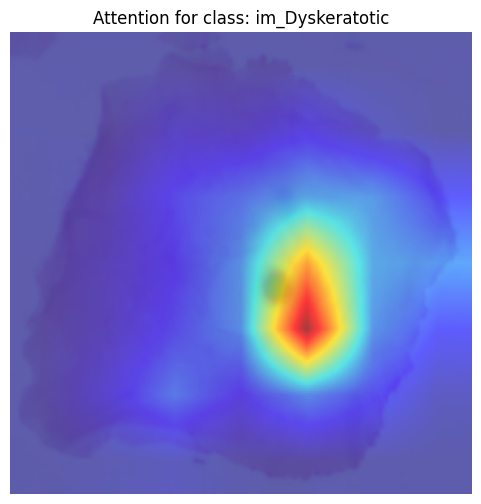

Saved specific class GradCAM visualization to gradcam_specific_class_outputs/gradcam_specific_class_im_Koilocytotic_001_01_processed.png


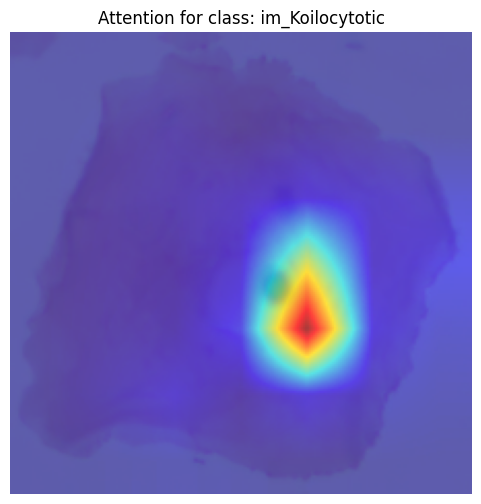

Saved specific class GradCAM visualization to gradcam_specific_class_outputs/gradcam_specific_class_im_Metaplastic_001_01_processed.png


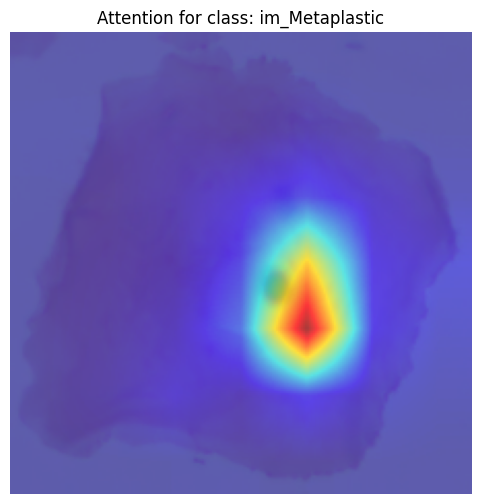

Saved specific class GradCAM visualization to gradcam_specific_class_outputs/gradcam_specific_class_im_Parabasal_001_01_processed.png


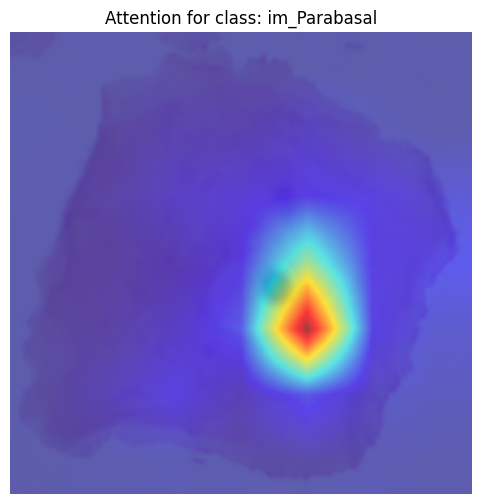

Saved specific class GradCAM visualization to gradcam_specific_class_outputs/gradcam_specific_class_im_Superficial-Intermediate_001_01_processed.png


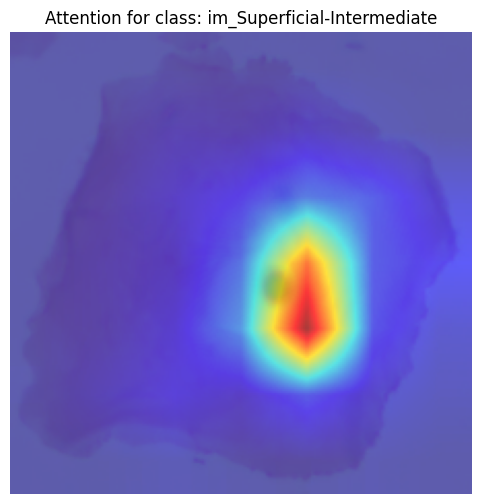

In [54]:
def visualize_specific_class(model, cam, image_path, target_class_idx, class_names, save_dir=None):
    """Visualize activation for a specific target class."""

    original_pil, input_tensor = get_image_tensor(image_path)
    rgb_img = np.array(original_pil.resize((224, 224)))
    rgb_img = np.float32(rgb_img) / 255

    # Create target for specific class
    targets = [ClassifierOutputTarget(target_class_idx)]

    # Generate CAM
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    plt.figure(figsize=(6, 6))
    plt.imshow(visualization)
    plt.title(f"Attention for class: {class_names[target_class_idx]}")
    plt.axis('off')

    if save_dir:
        target_class_name = class_names[target_class_idx]
        # Change extension to .png for saving
        original_name = Path(image_path).stem
        save_path = Path(save_dir) / f"gradcam_specific_class_{target_class_name}_{original_name}.png"
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path)
        print(f"Saved specific class GradCAM visualization to {save_path}")

    plt.show()

# Example usage (if images exist)
if image_files:
    sample_img = image_files[0]
    print(f"Analyzing specific class activations for: {sample_img.name}")

    # Define a save directory for specific class visualizations
    SPECIFIC_CLASS_SAVE_DIR = Path("./gradcam_specific_class_outputs")
    if not SPECIFIC_CLASS_SAVE_DIR.exists():
        SPECIFIC_CLASS_SAVE_DIR.mkdir(parents=True, exist_ok=True)
        print(f"Created directory: {SPECIFIC_CLASS_SAVE_DIR}")

    # Visualize for all classes to see what features trigger each class
    for i, name in enumerate(class_names):
        visualize_specific_class(model, cam, sample_img, i, class_names, save_dir=SPECIFIC_CLASS_SAVE_DIR)
